In [24]:
import pandas as pd
import polars as pl
import numpy as np
import panel as pn
pn.extension('tabulator')
from panel.interact import interact

import hvplot.pandas

import holoviews as hv
from holoviews import opts
hv.extension('bokeh')



In [2]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import imageio
import ipywidgets

In [56]:
pl_udemy = pl.read_parquet(r"C:\Users\ornal\Desktop\Data Analitics\PI03-Analytics\udemy.parquet")
pd_udemy = pl_udemy.to_pandas()

In [5]:
pl_coursera = pl.read_parquet(r"C:\Users\ornal\Desktop\Data Analitics\PI03-Analytics\coursera.parquet")
pd_coursera = pl_coursera.to_pandas()

In [140]:
pl_edx = pl.read_csv(r"C:\Users\ornal\Desktop\Data Analitics\PI03-Analytics-Origen\edx.csv")
pd_edx = pl_edx.to_pandas()

In [ ]:
pl_edx.columns

In [118]:
pl_review = pl.read_parquet(r"C:\Users\ornal\Desktop\Data Analitics\PI03-Analytics\reviews.parquet")
pd_review = pl_review.to_pandas()

In [161]:
pd_review.columns

Index(['reviews', 'reviewers', 'date_reviews', 'rating', 'course_id'], dtype='object')

## Ventas por año

In [58]:
plu_group_year = (
  pl.read_csv(r"C:\Users\ornal\Desktop\Data Analitics\PI03-Analytics-Origen\udemy.csv", parse_dates=True)
  .with_column(pl.col('published_timestamp').cast(pl.Datetime).dt.year().alias('year'))  
  .groupby('year')
  .agg(
  [
    pl.col('price').count().alias('cantidad_cursos')
  ]
  )
  .sort('year')  
)
plu_group_year

year,cantidad_cursos
i32,u32
2011,5
2012,45
2013,202
2014,491
2015,1014
2016,1206
2017,715


In [10]:
pdu_group_year = plu_group_year.to_pandas()

In [11]:
ipdu_group_year = pdu_group_year.interactive()

In [12]:
u_year_pipeline = (
    ipdu_group_year
    #.to_frame()
    .reset_index()
    .sort_values('year')
    .reset_index(drop=True)
)

In [13]:
year_plot = u_year_pipeline.hvplot('year','cantidad_cursos')
year_plot

## Agrupar por Precio

In [59]:
udemy_group_precio = (
  pl_udemy
  .filter(pl.col('price') != 0)  
  .groupby('price')
  .agg(
  [
    pl.col('price').count().alias('cantidad_cursos')
  ]
  )
  .sort('price')  
)
#udemy_group_precio

In [60]:
edx_group_precio = (
  pl_edx
  .filter(pl.col('price') != 0)  
  .groupby('price')
  .agg(
  [
    pl.col('price').count().alias('cantidad_cursos')
  ]
  )
  .sort('price')  
)
#edx_group_precio

In [68]:
group_precio = (
    pl.concat([udemy_group_precio,edx_group_precio],how='vertical')
    .groupby('price')
    .agg(
     pl.col('cantidad_cursos').sum()
    )
    .sort('price')
)
#group_precio

In [71]:
i_group_precio = group_precio.to_pandas().interactive()

In [79]:
precio_pipeline = (
    i_group_precio
    #.to_frame()
    .reset_index()
    .sort_values('price')
    .reset_index(drop=True)
)

In [80]:
precio_plot = precio_pipeline.hvplot('price','cantidad_cursos')
precio_plot

## Agrupar por nivel

In [106]:
udemy_group_nivel = (
  pl_udemy
  .groupby('level')
  .agg(
  [
    pl.col('price').mean().alias('precio_promedio'),
    pl.col('price').count().alias('cantidad_cursos')
  ]
  )
  .sort(['level','precio_promedio'])  
)
udemy_group_nivel = udemy_group_nivel.with_column(pl.col('level').alias('nivel_complejidad'))
udemy_group_nivel = udemy_group_nivel.select(pl.exclude('level'))

In [107]:
udemy_group_nivel = (
       udemy_group_nivel.with_column(pl.col('nivel_complejidad')
       .apply(lambda x: '1'+x if x == 'All Levels' else x)                 
       .apply(lambda x: '2'+x if x == 'Beginner Level' else x)                 
       .apply(lambda x: '3'+x if x == 'Intermediate Level' else x)                                  
       .apply(lambda x: '4'+x if x == 'Expert Level' else x)                                  
       .alias('level1'))
       .sort('level1') 
       ) 
udemy_group_nivel = udemy_group_nivel.select(pl.exclude('level1'))

In [142]:
pl_edx = pl_edx.with_column(
     pl.col('Level')
     .apply(lambda x: 'Beginner Level' if x == 'Introductory' else x).alias('nivel_complejidad')
)

In [143]:
pl_edx = pl_edx.with_column(
     pl.col('nivel_complejidad')
     .apply(lambda x: 'Intermediate Level' if x == 'Intermediate' else x)
     .apply(lambda x: 'Expert Level' if x == 'Advanced' else x)
)

In [144]:
pl_edx = pl_edx.select(['title', 'n_enrolled', 'course_type', 'subject','language', 'horas', 'price','nivel_complejidad'])
pd_edx = pl_edx.to_pandas()                

In [145]:
pd_edx.columns

Index(['title', 'n_enrolled', 'course_type', 'subject', 'language', 'horas',
       'price', 'nivel_complejidad'],
      dtype='object')

In [147]:
edx_group_nivel = (
  pl_edx
  .groupby('nivel_complejidad')
  .agg(
  [
    pl.col('price').mean().alias('precio_promedio'),
    pl.col('price').count().alias('cantidad_cursos')
  ]
  )
  .sort(['nivel_complejidad','precio_promedio'])  
)

In [148]:
edx_group_nivel = (
       edx_group_nivel.with_column(pl.col('nivel_complejidad')
       .apply(lambda x: '1'+x if x == 'All Levels' else x)                 
       .apply(lambda x: '2'+x if x == 'Beginner Level' else x)                 
       .apply(lambda x: '3'+x if x == 'Intermediate Level' else x)                                  
       .apply(lambda x: '4'+x if x == 'Expert Level' else x)                                  
       .alias('level1'))
       .sort('level1') 
       ) 
edx_group_nivel = edx_group_nivel.select(pl.exclude('level1'))

In [149]:
group_nivel = pl.concat(
    [
        udemy_group_nivel.select(['nivel_complejidad','precio_promedio','cantidad_cursos']),
        edx_group_nivel.select(['nivel_complejidad','precio_promedio','cantidad_cursos'])
    ]
    ,how='vertical'
)

In [150]:
group_nivel = (
  group_nivel
  .groupby('nivel_complejidad')
  .agg(
  [
    pl.col('precio_promedio').mean(),
    pl.col('cantidad_cursos').sum()
  ]
  ) 
)

In [151]:
i_group_nivel = group_nivel.to_pandas().interactive()

In [152]:
nivel_pipeline = (
    i_group_nivel
    #.to_frame()
    .reset_index()
    #.sort_values('nivel_complejidad')
    .reset_index(drop=True)
)

In [153]:
nivel_plot = nivel_pipeline.hvplot('nivel_complejidad','cantidad_cursos')
nivel_plot

## Agrupar por idioma

In [154]:
edx_group_idioma = (
  pl_edx
  .groupby('language')
  .agg(
  [
    pl.col('price').mean().alias('precio_promedio'),
    pl.col('price').count().alias('cantidad_cursos')
  ]
  )
)

In [156]:
i_group_idioma = edx_group_idioma.to_pandas().interactive()

In [157]:
idioma_pipeline = (
    i_group_idioma
    #.to_frame()
    .reset_index()
    #.sort_values('nivel_complejidad')
    .reset_index(drop=True)
)

In [158]:
idioma_plot = idioma_pipeline.hvplot('language','cantidad_cursos')
idioma_plot

## Agrupar por rating

In [203]:
#Index(['reviews', 'reviewers', 'date_reviews', 'rating', 'course_id'], dtype='object')
edx_group_rating = (
  pl_review
  #.groupby(['course_id','rating'])
  .groupby(['rating'])
  .agg(
  [
    pl.col('course_id').count().alias('cantidad_cursos (M)')
  ]
  )
)

In [204]:
edx_group_rating = edx_group_rating.with_column(pl.col('cantidad_cursos (M)').apply(lambda x: x/1000))

In [205]:
i_group_rating = edx_group_rating.to_pandas().interactive()

In [206]:
rating_pipeline = (
    i_group_rating
    #.to_frame()
    .reset_index()
    .sort_values('rating')
    .reset_index(drop=True)
)

In [207]:
rating_plot = rating_pipeline.hvplot(kind='bar',x='rating',y='cantidad_cursos (M)')
rating_plot

In [ ]:
edx_group_rating.filter(pl.col('course_id')=="oralcavity").to_pandas().hvplot('course_id','cantidad_cursos')

:Curve   [course_id]   (cantidad_cursos)

## Tabs

In [200]:
# widgets
tabs = pn.Tabs()

# funciones
@interact(x=(1,10))
def f1(x): return x+1

@interact(x=(1,10))
def f2(x): return x+2

@interact(x=(1,10))
def f3(x): return x+3

def ventas_year():
    return pn.Column('### Ventas por año (fuente: Udemy)',year_plot)

def ventas_precio():
    return pn.Column(precio_plot)

def ventas_level():
    return pn.Column(nivel_plot)

def ventas_nivel():
    return pn.Column(nivel_plot)

def ventas_idioma():
    return pn.Column(idioma_plot)

def ventas_rating():
    return pn.Column(rating_plot)


tabs.extend(
[
 ('Ventas',ventas_year()),
 ('Ventas x Precio',ventas_precio()),
 ('Ventas x Nivel',ventas_level()),
 ('Ventas x Idioma',ventas_idioma()),
 ('Ventas x Rating',ventas_rating())   
]
)
tabs

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Interactive(Interactive)
    [1] Column
        [0] Interactive(Interactive)
    [2] Column
        [0] Interactive(Interactive)
    [3] Column
        [0] Interactive(Interactive)
    [4] Column
        [0] Interactive(Interactive)

## Etiquetas

### Precio Promedio

In [14]:
def precio_promedio():
    precio_promedio_edx = pl_edx.select(pl.col('price').mean())
    precio_promedio_udemy = pl_udemy.select(pl.col('price').mean())
    precio_promedio = round( (precio_promedio_edx['price'][0] + precio_promedio_udemy['price'][0])/2  )
    return '#'+str(precio_promedio)

### Tiempo duracion Promedio

In [15]:
def tiempo_duracion():
    tiempo_duracion_edx = pl_edx.select(pl.col('horas').mean())
    tiempo_duracion_udemy = pl_udemy.select(pl.col('num_lectures').mean())
    tiempo_duracion = round( (tiempo_duracion_edx['horas'][0] + tiempo_duracion_udemy['num_lectures'][0])/2  )
    return '#'+str(tiempo_duracion)+'H'

### Idioma mas usado

In [16]:
def idioma():
    serie_idioma = pl_edx.to_pandas()['language'].value_counts()
    pd_idioma = pd.DataFrame(serie_idioma)
    pd_idioma = pd_idioma.reset_index()
    pd_idioma = pd_idioma.rename(columns={'language':'cantidad'})
    pd_idioma = pd_idioma.rename(columns={'index':'language'})
    return '#'+pd_idioma.iloc[0]['language']

In [17]:

#lista_udemy = lst()

## WordCloud

In [18]:
class MyClass: 
	def __init__(self, val): 
		self.val = val 

(-0.5, 399.5, 199.5, -0.5)

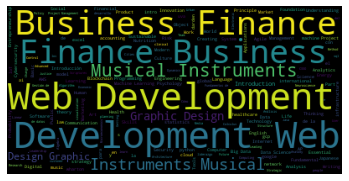

In [19]:
wordcloud = WordCloud().generate(pd_edx['title'].to_string() + ' ' + pd_udemy['subject'].to_string() + ' ' + pd_coursera['course_id'].to_string())
wordcloud.to_file(r"C:\Users\ornal\Desktop\Data Analitics\PI03-Analytics\wordcloud.png")
plt.imshow(wordcloud)
plt.axis('off')

## Imagen

In [20]:
png = pn.panel('wordcloud.png', width=300)

## Sidebar

Column
    [0] PNG(str, width=300)
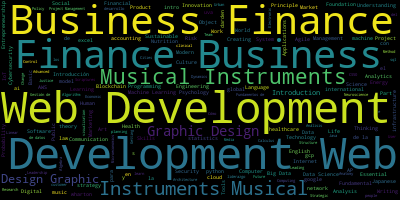

In [21]:
column_sidebar = pn.Column(png)
#column.append('\n')
column_sidebar

In [213]:
template = pn.template.FastListTemplate(
    title='Análisis del Mercado de Cursos Online',
    sidebar=[column_sidebar],
    main=[
        pn.Row(
            pn.Column(precio_promedio(),'#### Precio Promedio'),
            pn.Column('  '),
            pn.Column('#Python','#### tema más Usado'),
            pn.Column('  '),
            pn.Column(idioma(),'#### idioma más Usado'),
            pn.Column('  '),
            pn.Column(tiempo_duracion(),'#### Duración Promedio')
        ),
        pn.Row(pn.Column(tabs))
    ]
)

template.servable();
template.show()

Launching server at http://localhost:56812
